In [1]:
import pandas as pd
import os
import shutil

In [2]:
data_dir =  "C:/Users/RAHUL NAIR/Documents/all folders/Project folder/HAM dataset/HAM10000_images/"

dest_dir =  "C:/Users/RAHUL NAIR/Documents/all folders/Project folder/HAM dataset/reorganized/data/"

In [3]:
skin_df = pd.read_csv('C:/Users/RAHUL NAIR/Documents/all folders/Project folder/HAM dataset/HAM10000_metadata.csv')
print(skin_df['dx'].value_counts())

label=skin_df['dx'].unique().tolist()  #Extract labels into a list
label_images = []

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64


In [11]:
for i in label:
    os.mkdir(dest_dir + str(i) + "/")
    sample = skin_df[skin_df['dx'] == i]['image_id']
    label_images.extend(sample)
    for id in label_images:
        shutil.copyfile((data_dir + "/"+ id +".jpg"), (dest_dir + i + "/"+id+".jpg"))
    label_images=[]  

In [4]:
label.append("healthy")
label

['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec', 'healthy']

In [4]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [5]:
IMAGE_SIZE=64
BATCH_SIZE=16
CHANNELS=3
EPOCHS=35

In [ ]:
from sklearn.model_selection import train_test_split

filenames=['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec']

for filename in filenames:

    src_dir = f'C:/Users/RAHUL NAIR/Documents/all folders/Project folder/HAM dataset/reorganized/data/{filename}/'

    # Set the path to the new directory where the selected images will be stored
    dst_dir = f'C:/Users/RAHUL NAIR/Documents/all folders/Project folder/HAM dataset/reorganized/train/{filename}/'
    dst_dir1 = f'C:/Users/RAHUL NAIR/Documents/all folders/Project folder/HAM dataset/reorganized/test/{filename}/'

    # Create the new directory if it doesn't exist
    if not os.path.exists(dst_dir):
        os.makedirs(dst_dir)
    if not os.path.exists(dst_dir1):
        os.makedirs(dst_dir1)
    # Get a list of the images in the directory
    images = os.listdir(src_dir)
    len(images)
    
# Pandas dataframe
    df = pd.DataFrame({'image': images})
    train_images, test_images = train_test_split(df, test_size=0.25, random_state=42)
#     for image in train_images:
#          src_path = os.path.join(src_dir,image)
#          dst_path = os.path.join(dst_dir,image)
#          print(image)
#          print(src_path)
#          print(dst_path)
#          shutil.copy(src_path, dst_path)
# test_images.head()
#     # Copy the selected images to the new directory
    for image in train_images["image"]:
        src_path = os.path.join(src_dir, image)
        dst_path = os.path.join(dst_dir, image)
        shutil.copy(src_path, dst_path)
    for image in test_images["image"]:
        src_path1 = os.path.join(src_dir, image)
        dst_path1 = os.path.join(dst_dir1, image)
        shutil.copy(src_path1, dst_path1)
# images = os.listdir(src_dir)
# print(images)
# len(images)

In [31]:
from PIL import Image
folder="C:/Users/RAHUL NAIR/Documents/all folders/Project folder/HAM dataset/reorganized/test/healthy/"
folder2="C:/Users/RAHUL NAIR/Documents/all folders/Project folder/HAM dataset/reorganized/test/healthy2/"
for filename in os.listdir(folder):
    im = Image.open(folder+filename)
    im = im.convert("RGB")
    im.save(folder2+filename.split(".")[0]+".jpg")


In [ ]:
dataset_train=tf.keras.preprocessing.image_dataset_from_directory(
    "C:/Users/RAHUL NAIR/Documents/all folders/Project folder/HAM dataset/reorganized/train/",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE

)
dataset_test=tf.keras.preprocessing.image_dataset_from_directory(
    "C:/Users/RAHUL NAIR/Documents/all folders/Project folder/HAM dataset/reorganized/test",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE

)

In [7]:
dataset_train

<BatchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [8]:
class_names=dataset_train.class_names
class_names

['akiec', 'bcc', 'bkl', 'df', 'healthy2', 'mel', 'nv', 'vasc']

In [9]:
def get_dataset_partitions_tf(ds,ds1,train_split=0.8,val_split=0.2,shuffle=True,shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
        ds1=ds1.shuffle(shuffle_size,seed=12)

    train_size=int(train_split*ds_size)
    
    val_size=int(val_split*ds_size)

    train_ds=ds.take(train_size)

    val_ds=ds.skip(train_size)

    test_ds=ds1
    
    return train_ds,val_ds,test_ds

In [10]:
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset_train,dataset_test)

In [11]:
len(train_ds) ,len(val_ds),len(test_ds)

(376, 95, 158)

In [12]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255),
])

In [14]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
#     layers.experimental.preprocessing.RandomContrast(0.2,0.7),
#     layers.RandomBrightness(0.3),
#     layers.RandomZoom(0.5,0.3)
])

In [15]:
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes=7
kernel_size=(3,3)
filters_1=128
filters_2=64
filters_3=32
model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    #1
    layers.Conv2D(filters_1,kernel_size,activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.3),
    #2
    layers.Conv2D(filters_2,kernel_size,activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.3),
    #3
    layers.Conv2D(filters_3,kernel_size,activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.3),
#     #4
#     layers.Conv2D(filters_3,kernel_size,activation='relu'),
#     layers.MaxPooling2D((2,2)),
#     layers.Dropout(0.3),
#     #5
#     layers.Conv2D(filters_3,kernel_size,activation='relu'),
#     layers.MaxPooling2D((2,2)),
#     layers.Dropout(0.3),
#     #6
#     layers.Conv2D(filters_3,kernel_size,activation='relu'),
#     layers.MaxPooling2D((2,2)),
#     layers.Dropout(0.3),
#     #7
#     layers.Conv2D(64,(3,3),activation='relu'),
#     layers.MaxPooling2D((2,2)),
#     #8
#     layers.Conv2D(64,(3,3),activation='relu'),
#     layers.MaxPooling2D((2,2)),

    layers.Flatten(),

    
    layers.Dense(16,activation='relu'),
   
    
    
    layers.Dense(n_classes,activation='softmax')
])
model.build(input_shape=input_shape)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (16, 64, 64, 3)           0         
                                                                 
 sequential_1 (Sequential)   (None, 64, 64, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 62, 62, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 128)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 31, 31, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        73792     
                                                      

In [16]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history=model.fit(
        train_ds,
        epochs=35,
        batch_size=BATCH_SIZE,
        verbose=1,
        validation_data=val_ds
    )

Epoch 1/35


In [28]:
scores=model.evaluate(test_ds)

157/157 [==============================] - 2s 7ms/step - loss: 0.7524 - accuracy: 0.7327


In [30]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [34]:
acc=history.history["accuracy"]
val_acc=history.history["val_accuracy"]
loss=history.history["loss"]
val_loss=history.history["val_loss"]

Text(0.5, 1.0, 'Training and Validation Loss')

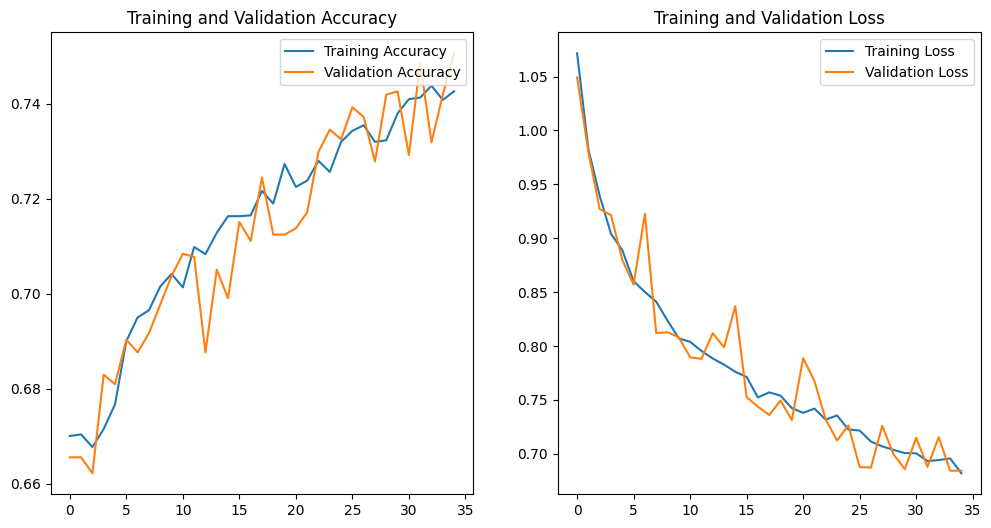

In [35]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label="Training Accuracy")
plt.plot(range(EPOCHS),val_acc,label="Validation Accuracy")
plt.legend(loc="upper right")
plt.title("Training and Validation Accuracy")

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label="Training Loss")
plt.plot(range(EPOCHS),val_loss,label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")

1/1 [==============================] - 0s 17ms/step


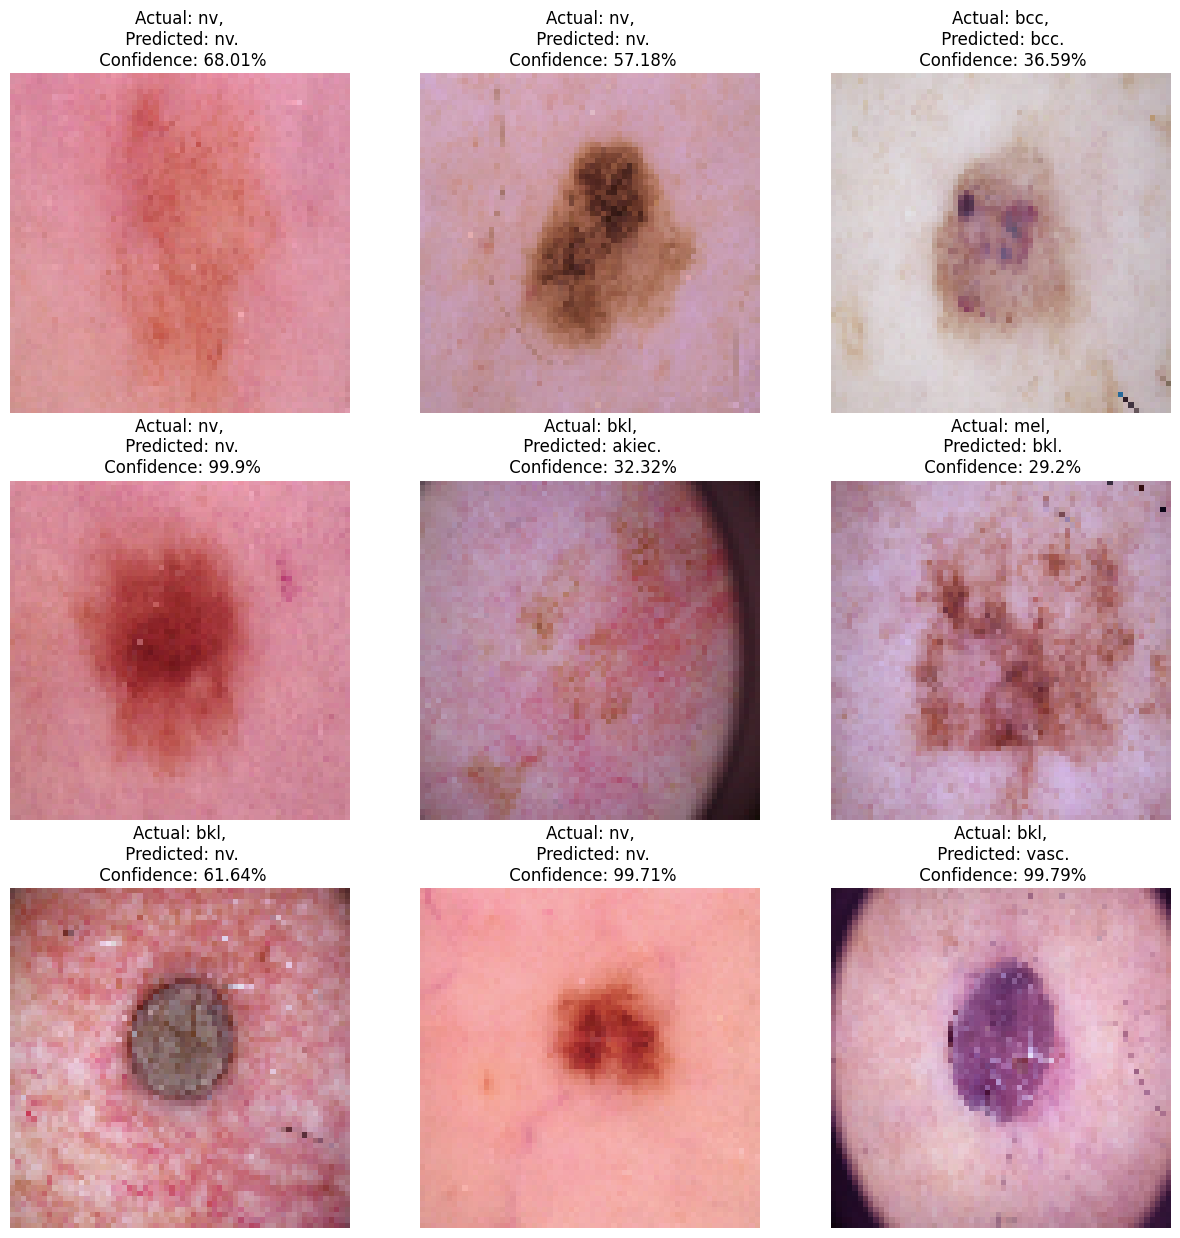

In [36]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [37]:
import os
model.save(f"../models/3")

INFO:tensorflow:Assets written to: ../models/3\assets


INFO:tensorflow:Assets written to: ../models/3\assets
